In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set plot font to serif
rcParams['font.family'] = 'serif'
plt.rc('font', size=14)
plt.rc('axes', labelsize=16)

# Set color variables to make colors easier later
darkblue = '#072448'
lightblue = '#54d2d2'
yellow = '#ffcb00'
orange = '#f8aa4b'
pink = '#ff6150'
gray = '#a89cac'

In [2]:
# define some dictionaries to make it easy to loop over metallicities
cc = {'mw': pink,
      'lmc': orange,
      'smc': yellow,
      'izw': lightblue}

ldict = {'mw': 'Z = 0.014',
         'lmc': 'Z = 0.006',
         'smc': 'Z = 0.002',
         'izw': 'Z = 0.0002'}

wrdict = {'mw': 7.5,
          'lmc': 11,
          'smc': 17}

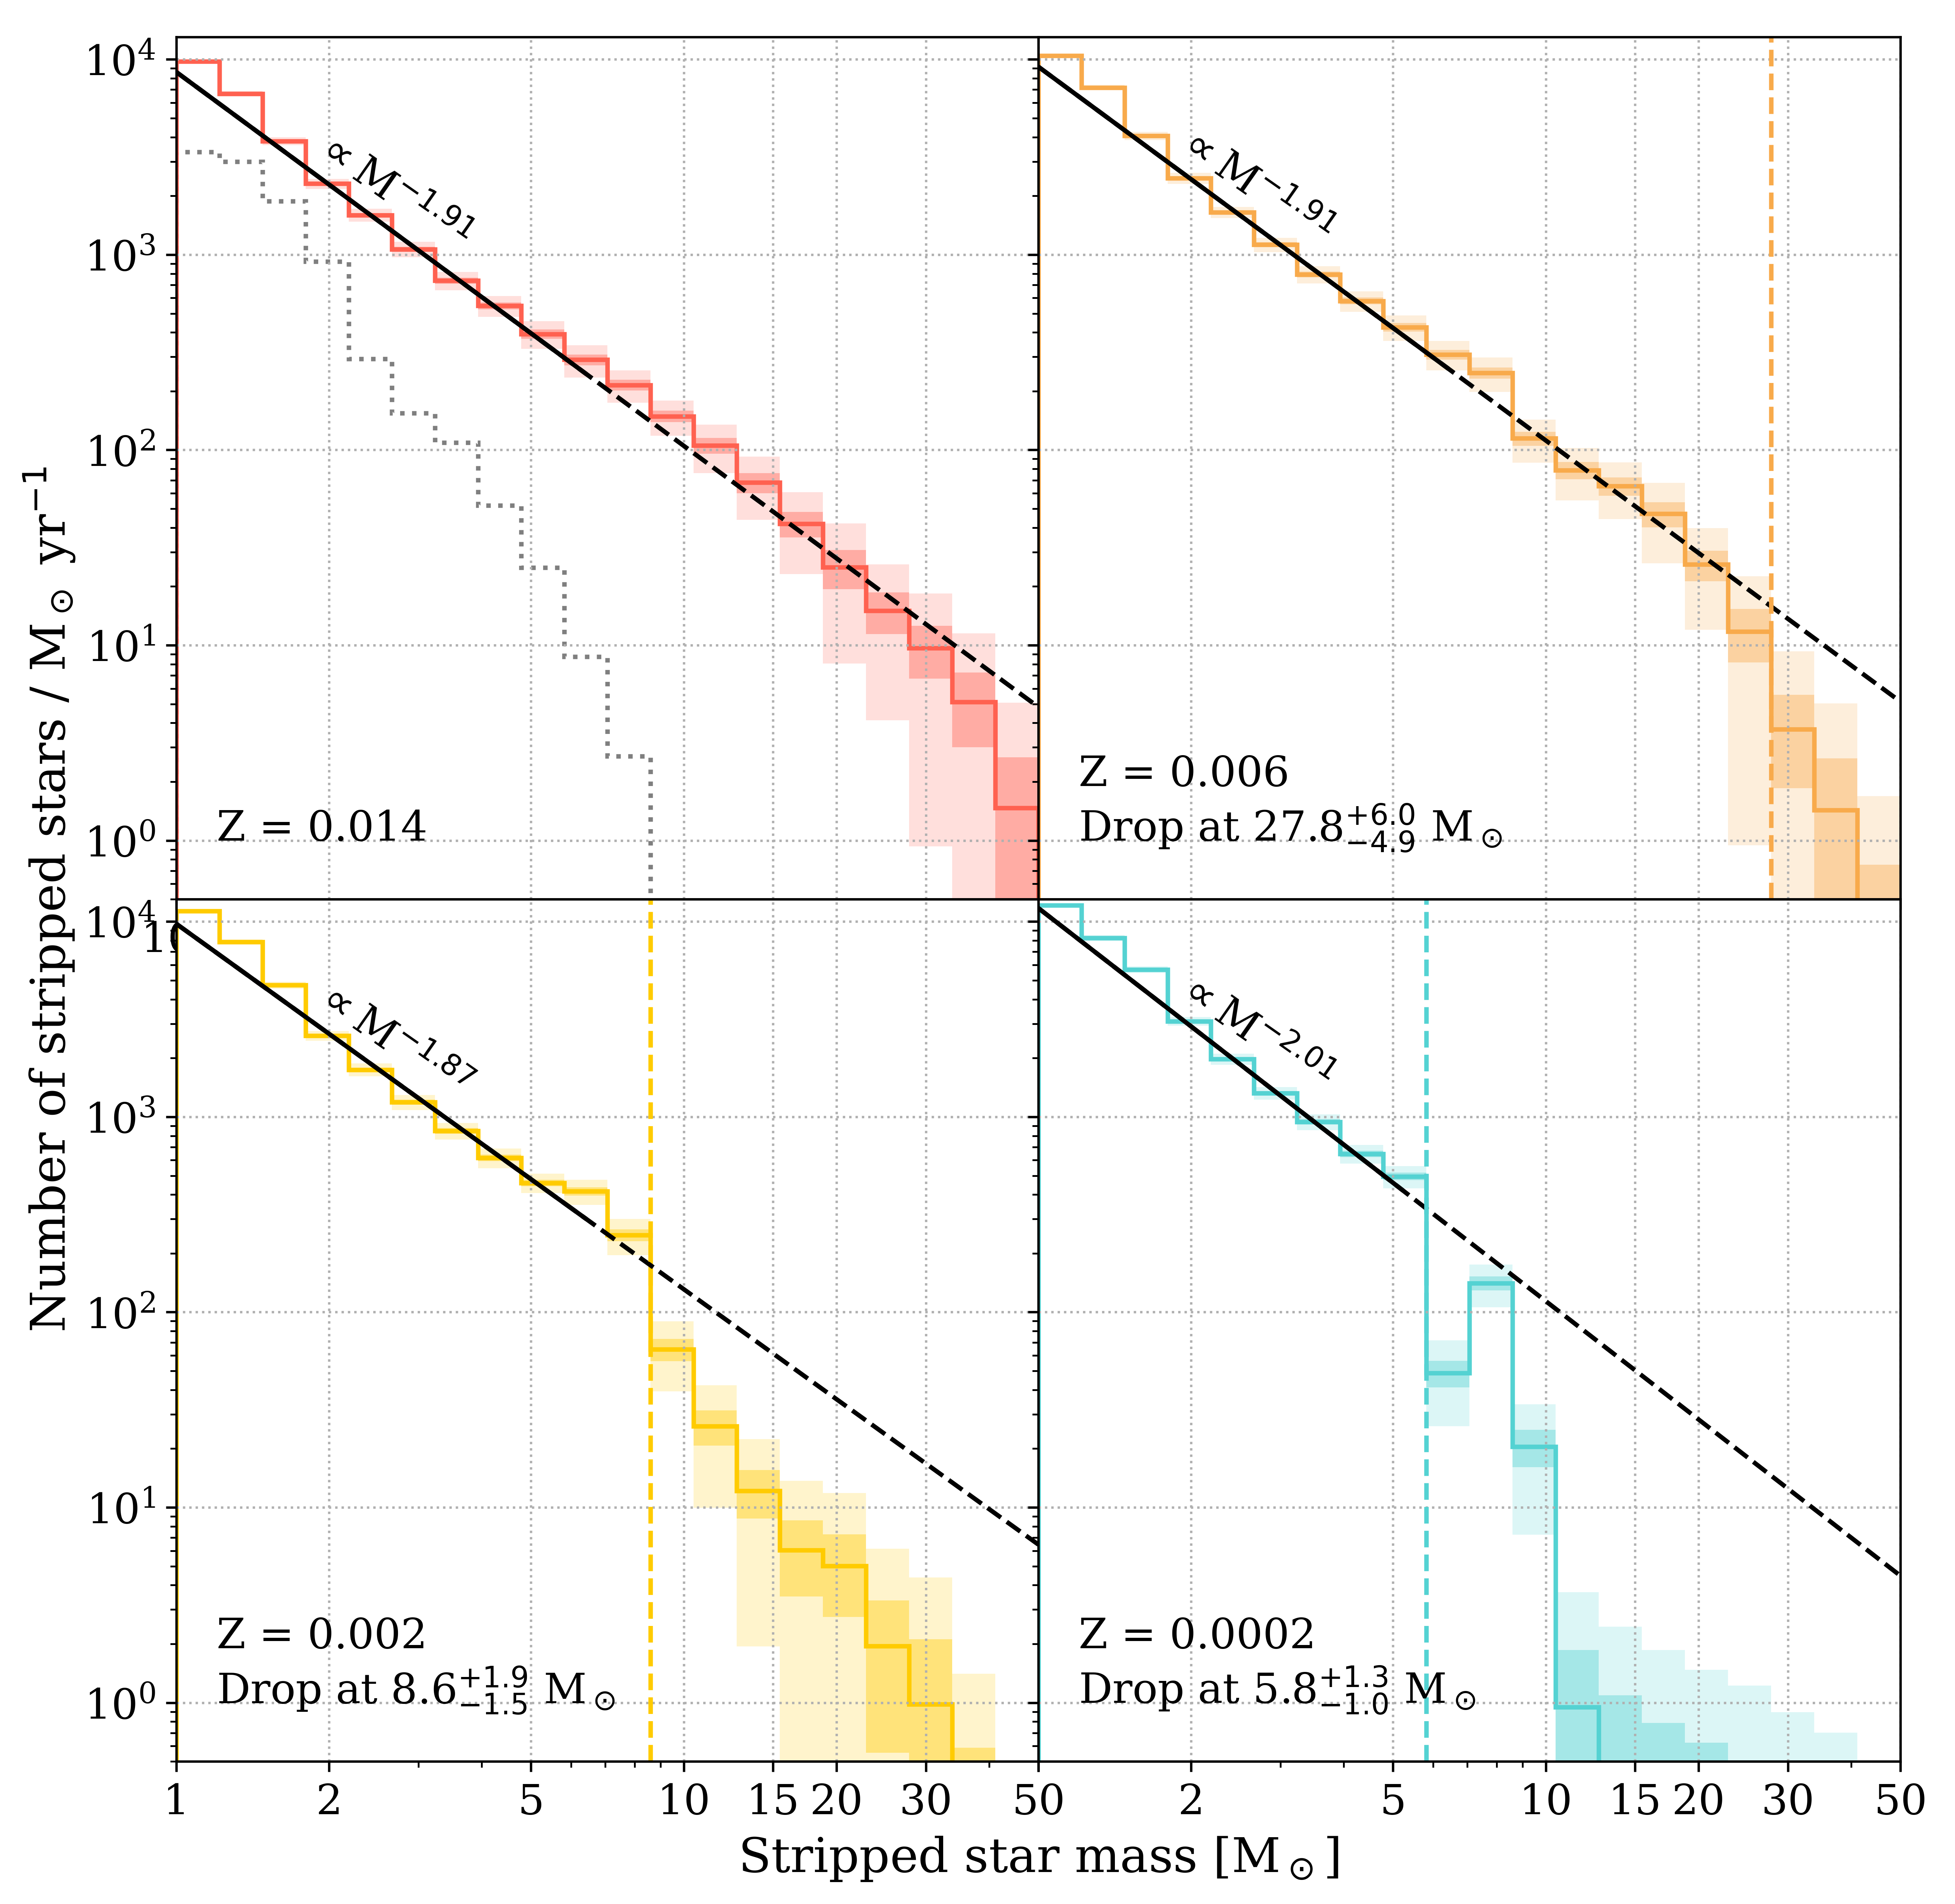

In [3]:
nbin = 20
bins = np.geomspace(1, 50, nbin)

# set up bins
bin_edges = np.geomspace(1, 50, nbin+1)
binwidths = bin_edges[1:] - bin_edges[:-1]

fig, ax = plt.subplots(2, 2, dpi=600, figsize=(8, 8), sharey=True)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)

for l, env in enumerate(cc.keys()):
    i = int(np.floor(l/2))
    j = l%2

    # load file
    datafile = f'../../data/moss/hist_grid_{env}.txt'
    hists = np.genfromtxt(datafile)
    n = int(len(hists[0])/nbin)

    # rebin histogram to the number of bins we want
    hists_rebin = np.array([np.sum(hists[:,n*i:n*(i+1)], axis=1) for i in range(int(len(hists[0])/n))]).T

    # calculate the means and standard deviations of each bin
    means = np.mean(hists_rebin, axis=0)
    stdevs = np.std(hists_rebin, axis=0)

    # Log plot with whole range
    ax[i][j].stairs(means, bin_edges, color=cc[env], lw=1.5)
    ax[i][j].fill_between(bin_edges[1:], means-stdevs, means+stdevs, step='pre',
                color=cc[env], alpha=0.4, edgecolor='None')
    ax[i][j].fill_between(bin_edges[1:], means-3*stdevs, means+3*stdevs, step='pre',
                color=cc[env], alpha=0.2, edgecolor='None')
    
    # Line fit
    # only fit to data where M_strip < 7 Msun
    for_fit = (bins<7)
    # for the lowest metallicity, fit to where M_strip < 6 Msun
    if env=='izw':
        for_fit = (bins<6)
    coeff = np.polyfit(np.log10(bins[for_fit]), np.log10(means[for_fit]), 1)
    fit = 10**np.polyval(coeff, np.log10(bins))
    ax[i][j].plot(bins, fit, c='k', ls='--')
    ax[i][j].plot(bins[for_fit], fit[for_fit], c='k')
    # Labeling the line
    idx = np.where(bins<2)[0][-1]
    ax[i][j].text(bins[idx], fit[idx]*1.3, fr'$\propto$M$^{{{coeff[0]:.2f}}}$', rotation=-35, rotation_mode='anchor')
    
    # Find where the drop is
    below_line = (fit > (means+3*stdevs))
    drop = np.where(np.max(bins[~below_line])==bins)[0][0] + 1
    
    if env != 'mw':
        # Errorbars on the drop
        uplim = binwidths[drop]
        lowlim = binwidths[drop-1]
        ax[i][j].axvline(bin_edges[drop], c=cc[env], ls='--')
        droplabel = fr'Drop at {bin_edges[drop]:.1f}$^{{+{uplim:.1f}}}_{{-{lowlim:.1f}}}$ M$_\odot$'
        ax[i][j].text(1.2, 1, f'{ldict[env]}\n{droplabel}')
    else:
        # Z=0.014 does not exhibit a drop so just print metallicity label
        ax[i][j].text(1.2, 1, ldict[env])

    # Axis formatting
    ax[i][j].set_xscale('log')
    ax[i][j].set_yscale('log')
    ax[i][j].set_xlim(1, 50)
    ax[i][j].set_ylim(0.5, 1.3e4)
    ax[i][j].set_xticks([1, 2, 5, 10, 15, 20, 30, 50])
    ax[i][j].grid(ls=':')

# plot Yungelson+24 data
ybin_edges = np.linspace(1, 8, 15)
ybin_centers = np.mean([ybin_edges[:-1], ybin_edges[1:]], axis=0)
bin_centers = np.mean([bin_edges[:-1], bin_edges[1:]], axis=0)
ymask = (bin_edges < np.max(ybin_edges)+1)

ydata = np.genfromtxt('../../data/yungelson_extracted.csv', skip_header=1, delimiter=',')[1:,1] / 2
yinterp = np.interp(bin_centers, ybin_centers, ydata)[ymask[:-1]][:-1]
ydata_new = yinterp * np.sum(ydata) / np.sum(yinterp)
ax[0][0].stairs(ydata_new, bin_edges[ymask], color='k', lw=1.5, label='Yungelson+24', zorder=0, alpha=0.5, ls=':')

# Axis formatting
ax[1][0].set_xticklabels(['1', '2', '5', '10', '15', '20', '30', '50'])
ax[1][1].set_xticklabels([' ', '2', '5', '10', '15', '20', '30', '50'])
# Common axis labels
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel(r'Stripped star mass [M$_\odot$]')
plt.ylabel(r'Number of stripped stars / M$_\odot$ yr$^{-1}$')

plt.savefig('../figures/Mdist.png', bbox_inches='tight')